In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

#from feature_engine import discretizers as dsc

import networkx as nx
import pylab as plt
import time

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_excel('Dataset\\World 2500 (2004-2020)\\SB2020_World2500.xlsx')

In [3]:
csfont = {'fontname':'Century'}
hfont = {'fontname':'Arial'}

In [23]:
df.head()

,World rank,Company,Country,Region,Industry,R&D 2019 (€million),R&D one-year growth (%),Net sales (€million),Net sales one-year growth (%),R&D intensity (%),Capex (€million),Capex one-year growth (%),Capex intensity (%),Op.profits (€million),Op.profits one-year growth (%),Profitability (%),Employees,Employees one-year growth (%),Market cap (€million),Market cap one-year growth (%)
0,1,ALPHABET,US,US,Software & Computer Services,23160.052790,24.369025,144077.817835,18.300090,16.074683,20961.369940,-6.328812,14.548645,31981.488840,10.225495,22.197372,118899.0,20.378451,317430.575596,-3.150728
1,2,MICROSOFT,US,US,Software & Computer Services,17152.396695,14.179900,127305.517325,13.645574,13.473412,13744.883355,10.886894,10.796770,47023.328030,23.042881,36.937384,163000.0,13.194444,936992.770363,22.202594
2,3,HUAWEI INVESTMENT & HOLDING,China,China,Technology Hardware & Equipment,16712.669680,31.228242,109416.700889,19.083558,15.274332,5238.499111,34.698290,4.787660,9916.303768,6.205739,9.062880,194000.0,3.191489,NaN,NaN
3,4,SAMSUNG ELECTRONICS,South Korea,RoW,Electronic & Electrical Equipment,15524.997456,8.270881,177139.830909,-5.484865,8.764261,22002.212850,-6.407620,12.420816,21349.349739,-52.844151,12.052258,287439.0,-7.166941,201949.731020,-15.544475
4,5,APPLE,US,US,Technology Hardware & Equipment,14435.643635,13.915426,231595.186970,-2.041078,6.233136,9342.176725,-21.167280,4.033839,56907.609150,-9.828204,24.572017,137000.0,3.787879,839713.172359,-14.198408


In [26]:
df.columns

Index(['World rank', 'Company', 'Country', 'Region', 'Industry',
       'R&D 2019 (€million)', 'R&D one-year growth (%)',
       'Net sales (€million)', 'Net sales one-year growth (%)',
       'R&D intensity (%)', 'Capex (€million)', 'Capex one-year growth (%)',
       'Capex intensity (%)', 'Op.profits (€million)',
       'Op.profits one-year growth (%)', 'Profitability (%)', 'Employees',
       'Employees one-year growth (%)', 'Market cap (€million)',
       'Market cap one-year growth (%)'],
      dtype='object')

In [4]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,World rank,R&D 2019 (€million),R&D one-year growth (%),Net sales (€million),Net sales one-year growth (%),R&D intensity (%),Capex (€million),Capex one-year growth (%),Capex intensity (%),Op.profits (€million),Op.profits one-year growth (%),Profitability (%),Employees,Employees one-year growth (%),Market cap (€million),Market cap one-year growth (%)
World rank,1.000000,-0.383961,0.000936,-0.341256,0.012055,0.034370,-0.269498,0.064027,0.033484,-0.216580,0.026193,-0.039137,-0.390158,-0.004737,-0.321887,0.043343
R&D 2019 (€million),-0.383961,1.000000,-0.005030,0.547258,-0.009064,-0.014874,0.489914,-0.029611,-0.008760,0.446558,-0.005231,0.015306,0.475353,-0.005950,0.698886,-0.020768
R&D one-year growth (%),0.000936,-0.005030,1.000000,-0.002577,-0.001279,-0.000230,-0.005880,0.011932,0.000444,-0.004847,0.028405,0.000319,-0.010627,0.000047,-0.008960,0.053677
Net sales (€million),-0.341256,0.547258,-0.002577,1.000000,-0.013620,-0.022447,0.813210,-0.047064,-0.012412,0.619457,-0.000019,0.022603,0.686925,0.007901,0.494129,-0.043195
Net sales one-year growth (%),0.012055,-0.009064,-0.001279,-0.013620,1.000000,-0.002564,-0.016116,0.012521,0.000504,-0.008269,0.900355,0.002787,-0.018278,-0.000177,-0.016323,0.023066
R&D intensity (%),0.034370,-0.014874,-0.000230,-0.022447,-0.002564,1.000000,-0.017227,-0.011684,0.466216,-0.014199,-0.001144,-0.972849,-0.029254,0.000406,-0.017123,-0.021826
Capex (€million),-0.269498,0.489914,-0.005880,0.813210,-0.016116,-0.017227,1.000000,-0.023271,-0.008059,0.616351,-0.005545,0.017325,0.546659,-0.002168,0.447584,-0.022121
Capex one-year growth (%),0.064027,-0.029611,0.011932,-0.047064,0.012521,-0.011684,-0.023271,1.000000,0.026412,-0.031541,0.006390,0.008900,-0.052124,-0.002585,-0.028401,0.019271
Capex intensity (%),0.033484,-0.008760,0.000444,-0.012412,0.000504,0.466216,-0.008059,0.026412,1.000000,-0.007426,0.001159,-0.455114,-0.012380,0.000686,-0.014433,-0.011872
Op.profits (€million),-0.216580,0.446558,-0.004847,0.619457,-0.008269,-0.014199,0.616351,-0.031541,-0.007426,1.000000,-0.004409,0.014459,0.338430,0.003931,0.546553,0.000345


In [39]:
df_country = df.groupby(by=["Country"])['R&D 2019 (€million)', 'Employees', 'Net sales (€million)', 'Capex (€million)'].agg(['sum','count'])

C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [41]:
def renaming_columns(df):##Renaming the columns
    for col in df.columns:
        new_col = col[0] + '_' + col[1].upper()
        df[new_col] = df[col[0]][col[1]]
        df.drop([col], axis = 1, inplace = True)
    return df

In [42]:
df_country = renaming_columns(df_country)

In [46]:
df_country.sort_values(by = 'R&D 2019 (€million)_SUM', ascending = False)

,R&D 2019 (€million)_SUM,R&D 2019 (€million)_COUNT,Employees_SUM,Employees_COUNT,Net sales (€million)_SUM,Net sales (€million)_COUNT,Capex (€million)_SUM,Capex (€million)_COUNT
,,,,,,,,
Country,,,,,,,,
US,347707.693605,775,10861474.0,771,4.917457e+06,712,300419.806626,768
China,118809.907333,536,11975635.0,527,3.608249e+06,534,246669.078306,533
Japan,114867.861631,309,8948719.0,306,3.174459e+06,309,222300.025212,308
Germany,86609.843548,124,6549377.0,123,1.781971e+06,123,109200.934853,117
France,33798.927043,68,4154552.0,67,1.100751e+06,65,85018.476486,68
South Korea,32938.530674,59,634086.0,16,9.819155e+05,59,93987.608716,58
UK,32011.007917,121,2657217.0,119,1.263160e+06,119,72727.306694,115
Switzerland,29785.306840,58,1348727.0,55,4.142675e+05,58,19203.558361,57


In [49]:
df_country.corr()

,,R&D 2019 (€million)_SUM,R&D 2019 (€million)_COUNT,Employees_SUM,Employees_COUNT,Net sales (€million)_SUM,Net sales (€million)_COUNT,Capex (€million)_SUM,Capex (€million)_COUNT
,,,,,,,,,
R&D 2019 (€million)_SUM,,1.000000,0.955116,0.855270,0.954921,0.935023,0.944591,0.904029,0.954152
R&D 2019 (€million)_COUNT,,0.955116,1.000000,0.919329,0.996786,0.966572,0.999083,0.945633,0.999951
Employees_SUM,,0.855270,0.919329,1.000000,0.920990,0.968111,0.930303,0.963332,0.918668
Employees_COUNT,,0.954921,0.996786,0.920990,1.000000,0.961756,0.995342,0.938434,0.996711
Net sales (€million)_SUM,,0.935023,0.966572,0.968111,0.961756,1.000000,0.970513,0.993097,0.965865
Net sales (€million)_COUNT,,0.944591,0.999083,0.930303,0.995342,0.970513,1.000000,0.951936,0.999085
Capex (€million)_SUM,,0.904029,0.945633,0.963332,0.938434,0.993097,0.951936,1.000000,0.945411
Capex (€million)_COUNT,,0.954152,0.999951,0.918668,0.996711,0.965865,0.999085,0.945411,1.000000


### COUNTRY SUM

In [385]:
df_country_sum = df.groupby(by=["Country"])['R&D 2019 (€million)', 'Employees', 'Net sales (€million)', 'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'].sum()

In [386]:
df_country_sum = df_country_sum[df_country_sum['Net sales (€million)'] > 0]
df_country_sum = df_country_sum[df_country_sum['Employees'] > 0]

<Figure size 1080x576 with 0 Axes>

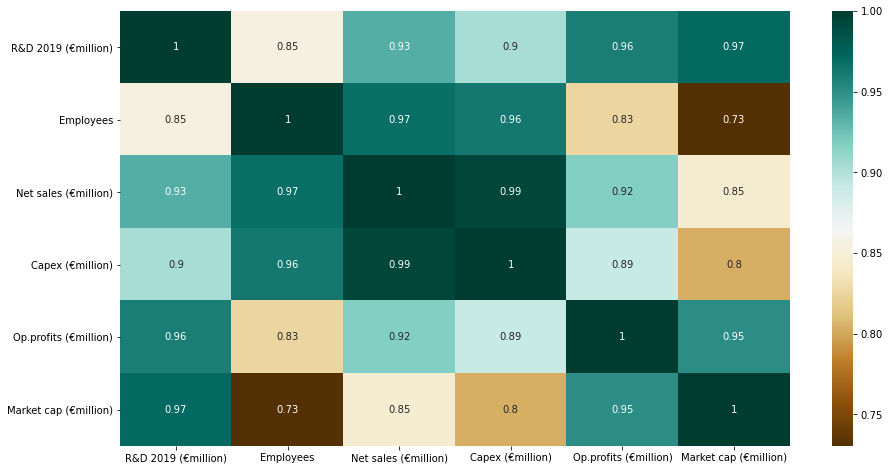

In [387]:
plt.figure(figsize = (15,8))
cormap = np.corrcoef(df_country_sum.values.T).round(2)
g = sns.heatmap(df_country_sum.corr(), cbar=True, annot = True, cmap='BrBG', yticklabels = df_country_sum.columns, xticklabels=df_country_sum.columns)

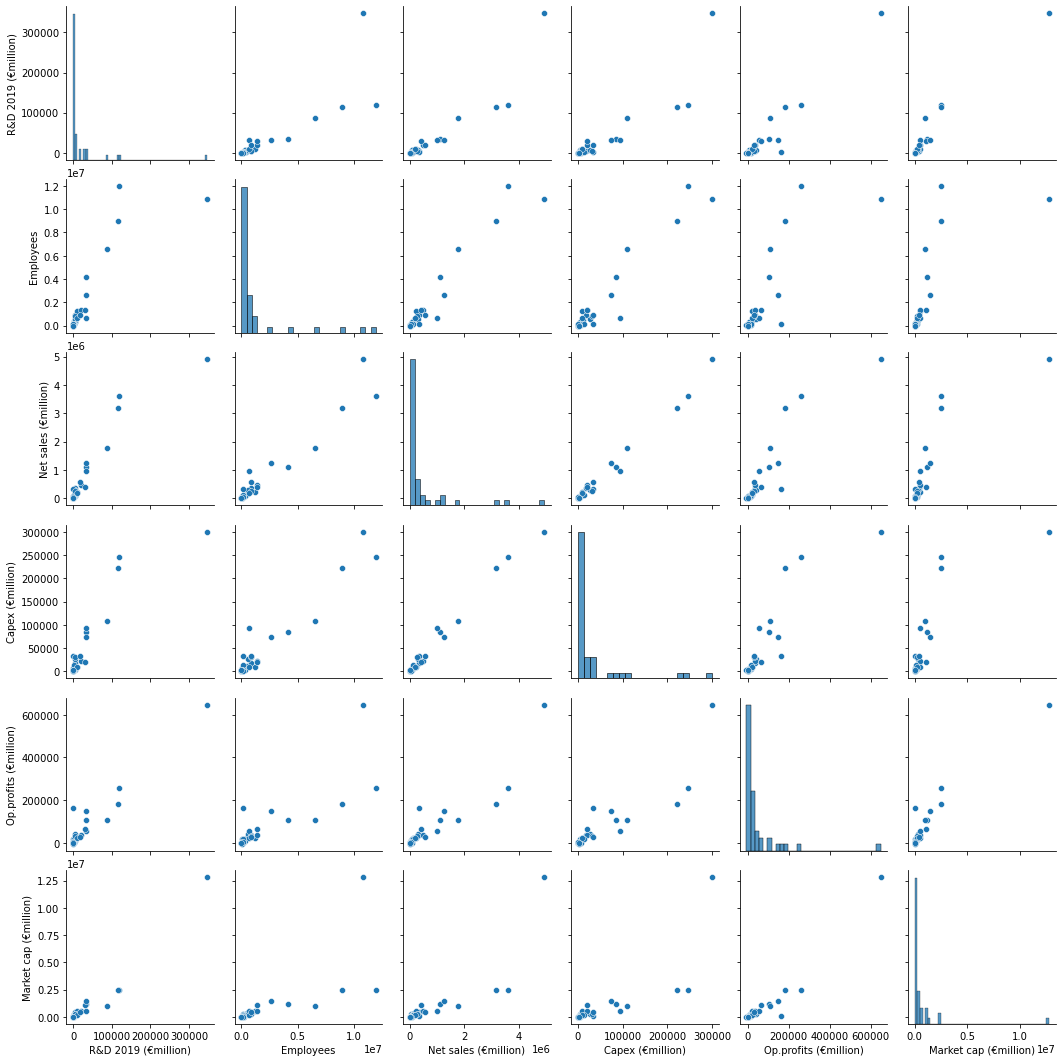

In [200]:
sns.pairplot(df_country_sum)

In [340]:
df_order = df_country_sum.sort_values(by='R&D 2019 (€million)', ascending = False)

Text(0.5, 0, 'Importance')

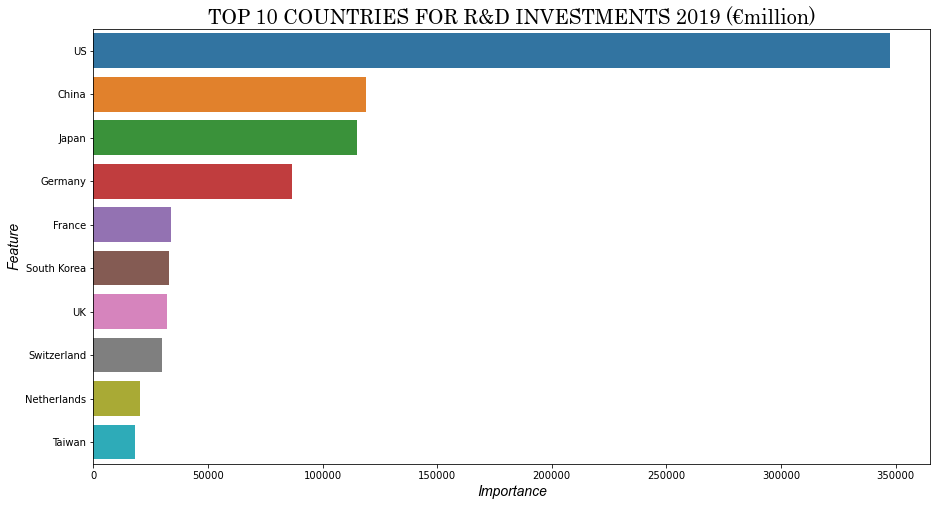

In [341]:
plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['R&D 2019 (€million)'], 
            y = df_order[:15].index)
plt.title('TOP 15 COUNTRIES FOR R&D INVESTMENTS 2019 (€million)', **csfont, size = 20)
plt.ylabel('Feature', **hfont, size = 14, style = 'italic')
plt.xlabel('Importance', **hfont, size = 14, style = 'italic')

In [27]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

In [388]:
for column in df_country_sum.columns:
    if df_country_sum[column].isnull().values.any() == True:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_country_sum[column] = imputer.fit_transform(np.array(df_country_sum[column]).reshape(-1,1))
        
df_country_sum = df_country_sum.round(decimals = 3)

scaler = StandardScaler()

features = scaler.fit_transform(df_country_sum[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                                               'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']])
df_country_sum[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']] = features
#y = df_country_sum['Net sales (€million)']
#df_country_sum.drop(['Op.profits (€million)', 'Net sales (€million)'], axis = 1, inplace = True)

In [389]:
X_train, X_test, y_train, y_test = train_test_split(df_country_sum, y, test_size=0.1, random_state=42)

In [359]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predicts = lr.predict(X_test)

In [360]:
r2_score(y_test, predicts)

0.9948311545041121

In [361]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predicts = lasso.predict(X_test)

In [362]:
r2_score(y_test, predicts)

-22.715139906678875

In [363]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predicts = ridge.predict(X_test)

In [364]:
r2_score(y_test, predicts)

0.9308047406410622

In [365]:
eNet = ElasticNet()
eNet.fit(X_train, y_train)
predicts = eNet.predict(X_test)

In [366]:
r2_score(y_test, predicts)

-8.062111792330855

In [367]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predicts = rf.predict(X_test)

In [368]:
r2_score(y_test, predicts)

0.9764302440064693

In [369]:
svr = SVR()
svr.fit(X_train, y_train)
predicts = svr.predict(X_test)

In [370]:
r2_score(y_test, predicts)

0.2612507780002934

In [24]:
df_x = df.drop(['World rank', 'Company', 'Country'], axis = 1)

In [440]:
nMax = 30
col_list_to_bin = []
for col in df_x.columns:
    print(col, ": ", len(df_x[col].unique()))
    if(len(df_x[col].unique()) > nMax):
        col_list_to_bin.append(col)

Region :  6
Industry :  38
R&D 2019 (€million) :  2451
R&D one-year growth (%) :  2480
Net sales (€million) :  2421
Net sales one-year growth (%) :  2399
R&D intensity (%) :  2423
Capex (€million) :  2429
Capex one-year growth (%) :  2431
Capex intensity (%) :  2383
Op.profits (€million) :  2474
Op.profits one-year growth (%) :  2472
Profitability (%) :  2406
Employees :  2059
Employees one-year growth (%) :  2171
Market cap (€million) :  2274
Market cap one-year growth (%) :  2184


In [437]:
col_list_to_bin[1:]

['R&D 2019 (€million)',
 'R&D one-year growth (%)',
 'Net sales (€million)',
 'Net sales one-year growth (%)',
 'R&D intensity (%)',
 'Capex (€million)',
 'Capex one-year growth (%)',
 'Capex intensity (%)',
 'Op.profits (€million)',
 'Op.profits one-year growth (%)',
 'Profitability (%)',
 'Employees',
 'Employees one-year growth (%)',
 'Market cap (€million)',
 'Market cap one-year growth (%)']

In [28]:
scaler = StandardScaler()

for column in df_x.columns:
    if df_x[column].isnull().values.any() == True:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_x[column] = imputer.fit_transform(np.array(df_x[column]).reshape(-1,1))
        
features = scaler.fit_transform(df_x[['R&D 2019 (€million)', 'R&D one-year growth (%)', 'Net sales (€million)', 'Net sales one-year growth (%)',
 'R&D intensity (%)', 'Capex (€million)', 'Capex one-year growth (%)','Capex intensity (%)', 'Op.profits (€million)', 'Op.profits one-year growth (%)', 'Profitability (%)', 'Employees', 'Employees one-year growth (%)', 'Market cap (€million)', 'Market cap one-year growth (%)']])
df_x[['R&D 2019 (€million)', 'R&D one-year growth (%)', 'Net sales (€million)', 'Net sales one-year growth (%)',
 'R&D intensity (%)', 'Capex (€million)', 'Capex one-year growth (%)','Capex intensity (%)', 'Op.profits (€million)', 'Op.profits one-year growth (%)', 'Profitability (%)', 'Employees', 'Employees one-year growth (%)', 'Market cap (€million)', 'Market cap one-year growth (%)']] = features

In [29]:
df_x = df_x.round(decimals = 3)

In [451]:
df_x.head()

,Region,Industry,R&D 2019 (€million),R&D one-year growth (%),Net sales (€million),Net sales one-year growth (%),R&D intensity (%),Capex (€million),Capex one-year growth (%),Capex intensity (%),Op.profits (€million),Op.profits one-year growth (%),Profitability (%),Employees,Employees one-year growth (%),Market cap (€million),Market cap one-year growth (%)
0,US,Software & Computer Services,18.839,-0.021,5.749,-0.034,-0.062,9.829,-0.169,-0.029,7.517,-0.021,0.064,1.963,-0.020,8.167,-0.071
1,US,Software & Computer Services,13.874,-0.022,5.037,-0.036,-0.062,6.350,-0.109,-0.032,11.148,-0.021,0.065,2.877,-0.024,24.735,0.339
2,China,Technology Hardware & Equipment,13.511,-0.021,4.278,-0.034,-0.062,2.249,-0.027,-0.036,2.191,-0.021,0.064,3.519,-0.029,0.000,0.000
3,RoW,Electronic & Electrical Equipment,12.530,-0.023,7.153,-0.045,-0.063,10.331,-0.169,-0.031,4.951,-0.021,0.064,5.455,-0.035,5.079,-0.271
4,US,Technology Hardware & Equipment,11.630,-0.022,9.466,-0.043,-0.063,4.228,-0.220,-0.037,13.534,-0.021,0.064,2.338,-0.029,22.134,-0.249


In [445]:
nBins = 10
est = KBinsDiscretizer(n_bins=nBins, encode='ordinal', strategy='uniform')
#ordinal --> Return the bin identifier encoded as an integer value.
#uniform --> All bins in each feature have identical widths.
est.fit(df_x[col_list_to_bin[1:]])
#assign binarized values to three new columns
df_x[['R&D 2019 (€million)', 'R&D one-year growth (%)', 'Net sales (€million)', 'Net sales one-year growth (%)', 'R&D intensity (%)', 'Capex (€million)', 'Capex one-year growth (%)', 'Capex intensity (%)', 'Op.profits (€million)', 'Op.profits one-year growth (%)', 'Profitability (%)','Employees','Employees one-year growth (%)','Market cap (€million)','Market cap one-year growth (%)']] = est.transform(df_x[col_list_to_bin[1:]])
df_x.head(4)
df_x = df_x.drop(col_list_to_bin[1:], axis=1)

KBinsDiscretizer(encode='ordinal', strategy='uniform')

,Region,Industry,R&D 2019 (€million),R&D one-year growth (%),Net sales (€million),Net sales one-year growth (%),R&D intensity (%),Capex (€million),Capex one-year growth (%),Capex intensity (%),Op.profits (€million),Op.profits one-year growth (%),Profitability (%),Employees,Employees one-year growth (%),Market cap (€million),Market cap one-year growth (%)
0,US,Software & Computer Services,4.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0
1,US,Software & Computer Services,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,4.0,0.0
2,China,Technology Hardware & Equipment,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0
3,RoW,Electronic & Electrical Equipment,3.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0,0.0


In [30]:
hc = HillClimbSearch(df_x, scoring_method=BicScore(df_x))
#The score to be optimized during structure estimation.  
#  Supported structure scores: k2score, bdeuscore, bicscore.
best_model = hc.estimate()
edges = list(best_model.edges())
model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))

# nx.draw(model, with_labels=True)
nx.draw(model, pos= nx.spring_layout(model), with_labels=True, node_size=2000,
        node_color="cyan", edge_color = 'black', width = 3, font_size = 20)
plt.show()

  0%|                                                                        | 2/1000000 [02:01<16831:57:41, 60.60s/it]


KeyboardInterrupt: 

In [447]:
# we can get parents or children
model.get_children('Industry')

['Region']

In [399]:
# Fitting the data to the model using Maximum Likelihood Estimator
model.fit(X_train, estimator=MaximumLikelihoodEstimator)

# Doing exact inference using Variable Elimination
infer = VariableElimination(model)

### AVERAGE

In [142]:
df_country_avg = df.groupby(by=["Country"])['R&D 2019 (€million)', 'Employees', 'Net sales (€million)', 'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'].mean()
df_country_avg.drop(index = 'Saudi Arabia', axis = 0, inplace = True) #Outlier

<Figure size 1080x576 with 0 Axes>

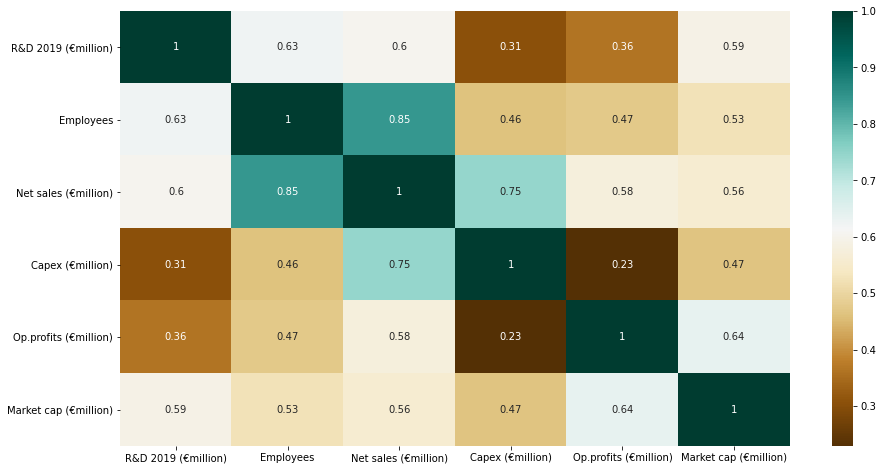

In [56]:
plt.figure(figsize = (15,8))
cormap = np.corrcoef(df_country_avg.values.T).round(2)
g = sns.heatmap(df_country_avg.corr(), cbar=True, annot = True, cmap='BrBG', yticklabels = df_country_avg.columns, xticklabels=df_country_avg.columns)

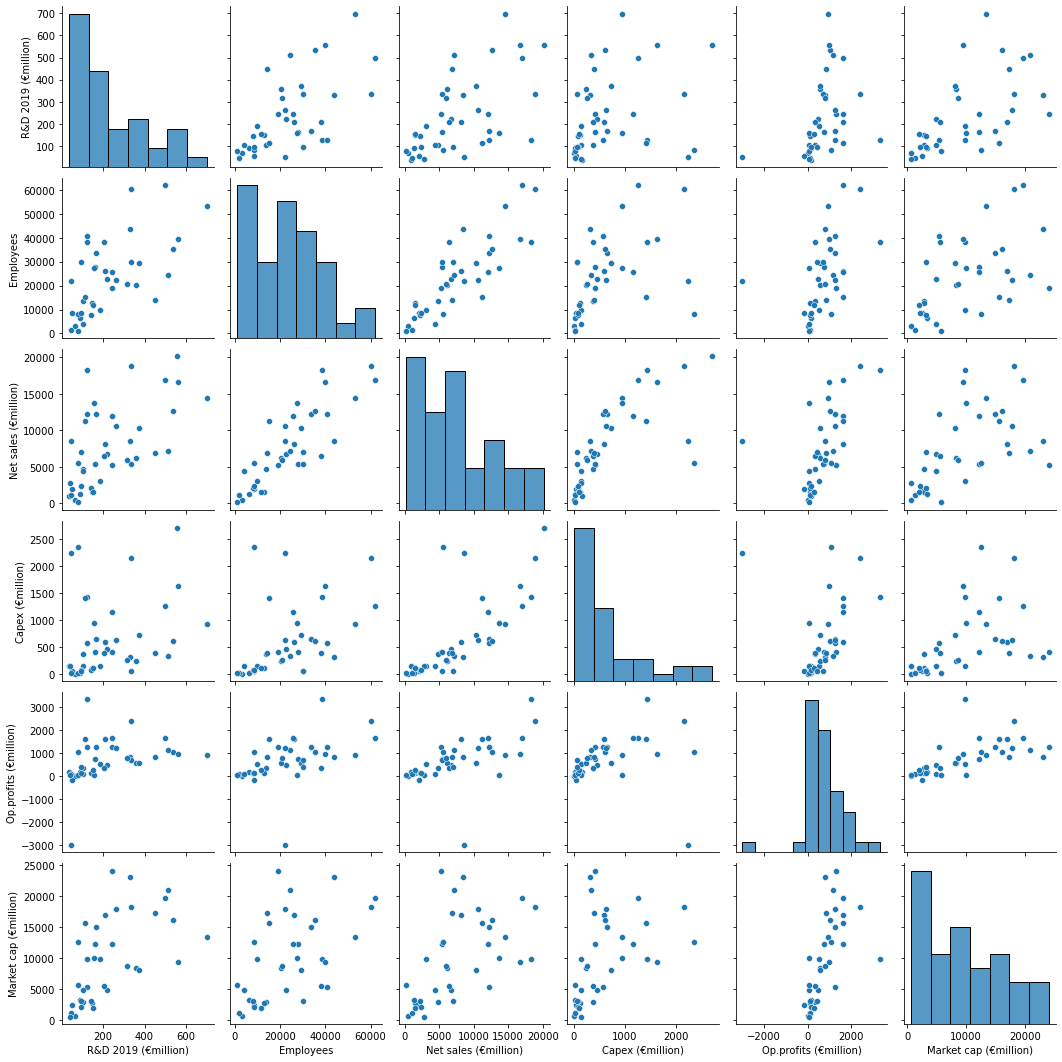

In [33]:
sns.pairplot(df_country_avg)

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='R&D 2019 (€million)', ylabel='Country'>

Text(0.5, 1.0, 'TOP 15 COUNTRIES FOR AVERAGE R&D INVESTMENTS 2019 (€million)')

Text(0, 0.5, 'Country')

Text(0.5, 0, 'R&D Investments 2019 (€million)')

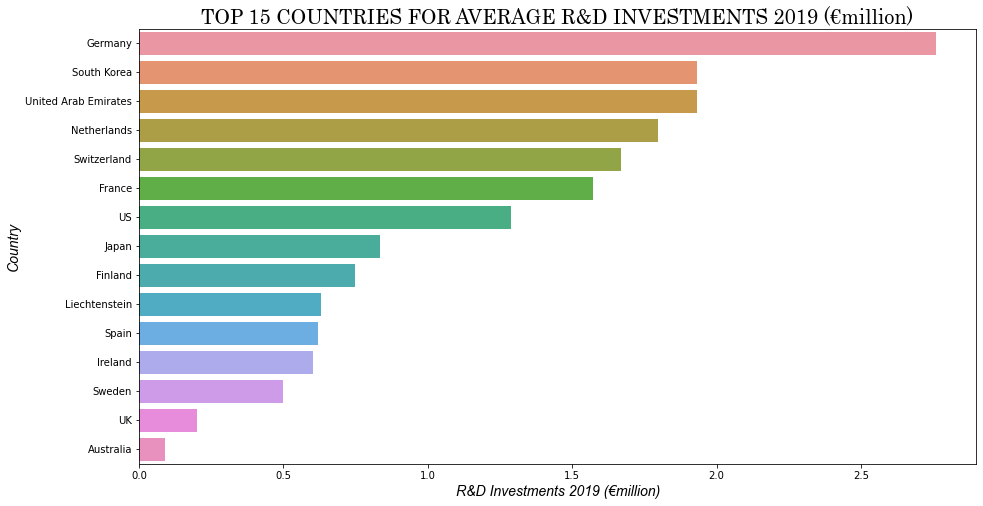

In [80]:
df_order = df_country_avg.sort_values(by='R&D 2019 (€million)', ascending = False)

plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['R&D 2019 (€million)'], 
            y = df_order[:15].index)
plt.title('TOP 15 COUNTRIES FOR AVERAGE R&D INVESTMENTS 2019 (€million)', **csfont, size = 20)
plt.ylabel('Country', **hfont, size = 14, style = 'italic')
plt.xlabel('R&D Investments 2019 (€million)', **hfont, size = 14, style = 'italic')

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Employees', ylabel='Country'>

Text(0.5, 1.0, 'TOP 15 COUNTRIES FOR AVERAGE EMPLOYEES')

Text(0, 0.5, 'Country')

Text(0.5, 0, 'Employees')

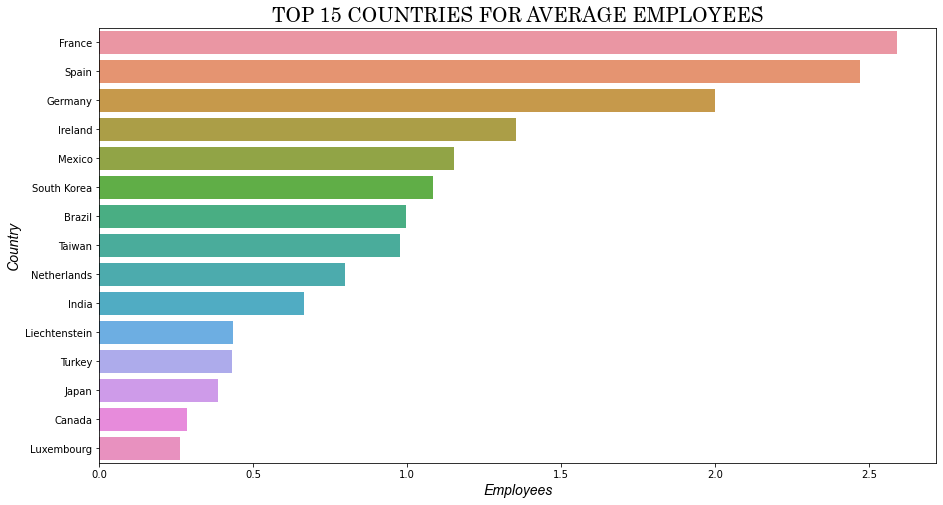

In [81]:
df_order = df_country_avg.sort_values(by='Employees', ascending = False)

plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['Employees'], 
            y = df_order[:15].index)
plt.title('TOP 15 COUNTRIES FOR AVERAGE EMPLOYEES', **csfont, size = 20)
plt.ylabel('Country', **hfont, size = 14, style = 'italic')
plt.xlabel('Employees', **hfont, size = 14, style = 'italic')

In [150]:
df_country_avg.columns

Index(['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
       'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'],
      dtype='object')

In [57]:
for column in df_country_avg.columns:
    if df_country_avg[column].isnull().values.any() == True:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_country_avg[column] = imputer.fit_transform(np.array(df_country_avg[column]).reshape(-1,1))
        
df_country_avg = df_country_avg.round(decimals = 3)

features = scaler.fit_transform(df_country_avg[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                                               'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']])
df_country_avg[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']] = features
y = df_country_avg['Net sales (€million)']
df_country_avg.drop(['Net sales (€million)'], axis = 1, inplace = True)

In [110]:
#x = df_country_avg['Employees']
#x = np.array(x).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(df_country_avg, y, test_size=0.1, random_state=42)

### Linear Regression

In [111]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predicts = lr.predict(X_test)

LinearRegression()

In [112]:
r2_score(y_test, predicts)

0.8148675410200115

In [113]:
math.sqrt(mean_squared_error(y_test, predicts))

0.4685183363006104

### Ridge

In [114]:
lasso = Ridge()
lasso.fit(X_train, y_train)
predicts = lasso.predict(X_test)

Ridge()

In [115]:
r2_score(y_test, predicts)

0.8074005319805748

In [116]:
math.sqrt(mean_squared_error(y_test, predicts))

0.4778733915516312

### SVR

In [117]:
svr = SVR()
svr.fit(X_train, y_train)
predicts = svr.predict(X_test)

SVR()

In [118]:
r2_score(y_test, predicts)

0.6479216204010425

In [119]:
math.sqrt(mean_squared_error(y_test, predicts))

0.6461078030259865

### Random Forest 

In [120]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predicts = rf.predict(X_test)

RandomForestRegressor()

In [121]:
r2_score(y_test, predicts)

0.8415832546587674

In [122]:
math.sqrt(mean_squared_error(y_test, predicts))

0.43339695022233204

### OLS

In [123]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

In [130]:
df_ols = pd.DataFrame()
df_ols['rd_investments'] = df_country_avg['R&D 2019 (€million)']
df_ols['employees'] = df_country_avg['Employees']

In [133]:
y, X = dmatrices('rd_investments ~ employees', data = df_ols, return_type = 'dataframe')
X = sm.add_constant(X)
olsr_results = sm.OLS(y, X).fit()
print(olsr_results.summary())

                            OLS Regression Results                            
Dep. Variable:         rd_investments   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     20.06
Date:                Tue, 11 May 2021   Prob (F-statistic):           6.12e-05
Time:                        11:56:00   Log-Likelihood:                -51.058
No. Observations:                  42   AIC:                             106.1
Df Residuals:                      40   BIC:                             109.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.714e-17      0.129  -7.53e-16      1.0

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Residuals plot from OLS Model')

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

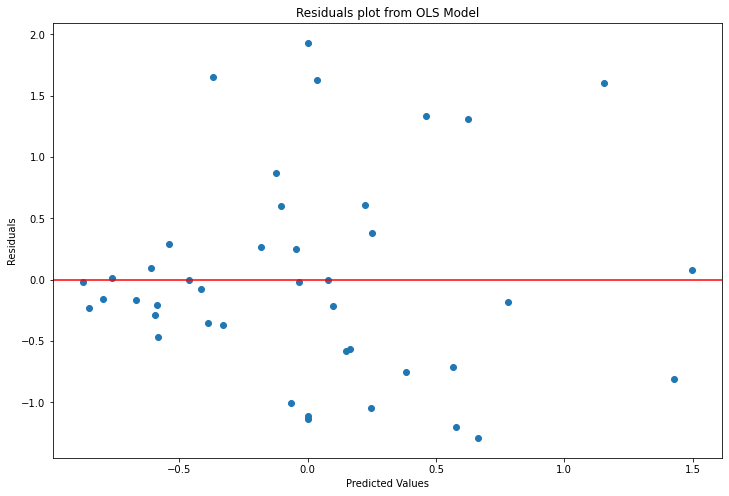

In [134]:
plt.figure(figsize=(12,8))
plt.scatter(olsr_results.predict(), olsr_results.resid)# print resids vs predictions
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residuals plot from OLS Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('LR_Residual_Plot')

<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='predict', ylabel='rd_investments'>

Text(0.5, 1.0, 'Actual Values vs Predicted Values')

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Actual Values')

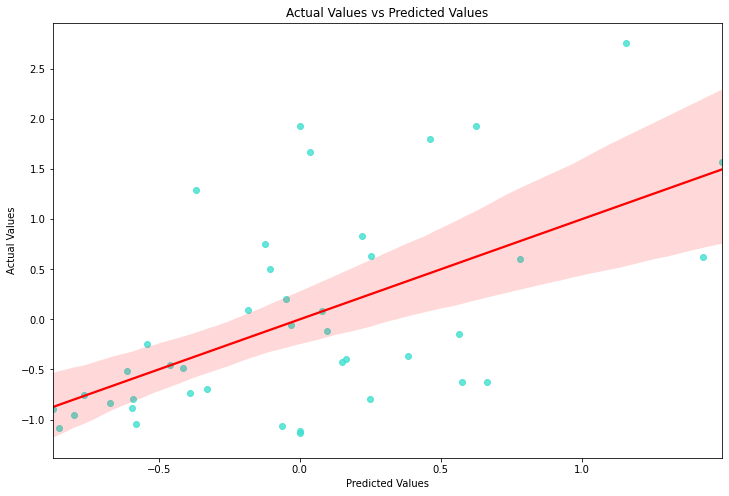

In [136]:
plt.figure(figsize=(12,8))
df_ols['predict'] = olsr_results.predict(X)
sns.regplot(x = 'predict', y = 'rd_investments', data = df_ols, scatter_kws={"color": "turquoise"}, line_kws={"color": "red"})
plt.title("Actual Values vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

In [140]:
for column in df_country_avg.columns:
    if df_country_avg[column].isnull().values.any() == True:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_country_avg[column] = imputer.fit_transform(np.array(df_country_avg[column]).reshape(-1,1))
        
df_country_avg = df_country_avg.round(decimals = 3)

In [143]:
df_country_avg.dropna(inplace = True)

In [145]:
lvl_rd = []
mean_rd = np.mean(df_country_avg['R&D 2019 (€million)'])
for x in df_country_avg['R&D 2019 (€million)']:
    if x >= mean_rd:
        lvl_rd.append('High')
    else:
        lvl_rd.append('Low')

df_country_avg['Level_R&D'] = lvl_rd

lvl_emp = []
mean_empl = np.mean(df_country_avg['Employees'])
for x in df_country_avg['Employees']:
    if x >= mean_empl:
        lvl_emp.append('High')
    else:
        lvl_emp.append('Low')

df_country_avg['Level_Employees'] = lvl_emp

  0%|                                                                           | 8/1000000 [00:00<15:34:03, 17.84it/s]


<Figure size 1080x720 with 0 Axes>

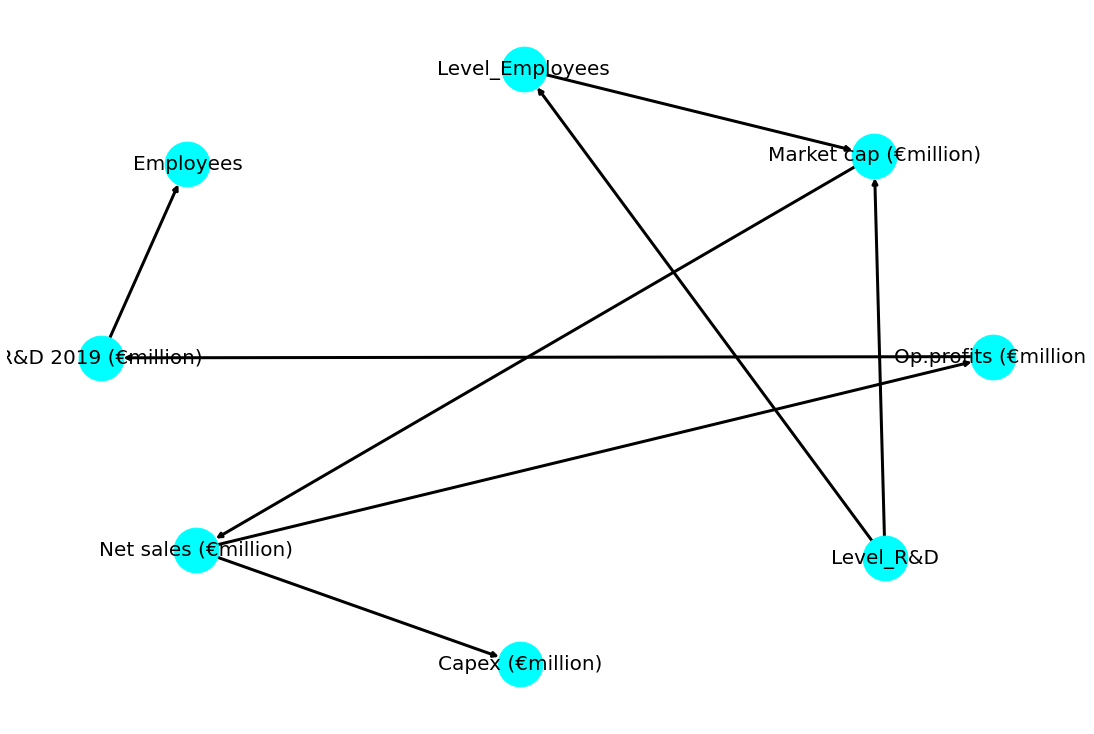

In [146]:
hc = HillClimbSearch(df_country_avg, scoring_method=BicScore(df_country_avg))
#The score to be optimized during structure estimation.  
#  Supported structure scores: k2score, bdeuscore, bicscore.
best_model = hc.estimate()
edges = list(best_model.edges())
model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))

# nx.draw(model, with_labels=True)
nx.draw(model, pos= nx.spring_layout(model), with_labels=True, node_size=2000,
        node_color="cyan", edge_color = 'black', width = 3, font_size = 20)
plt.show()

In [147]:
model.fit(df_country_avg, estimator=MaximumLikelihoodEstimator)

# Doing exact inference using Variable Elimination
infer = VariableElimination(model)

In [148]:
print(infer.query(variables=['Level_Employees', 'Level_R&D'], joint= True))

Eliminating: Employees: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 303.86it/s]

+-----------------+-----------------------+----------------------------------+
| Level_R&D       | Level_Employees       |   phi(Level_R&D,Level_Employees) |
+=================+=======================+==================================+
| Level_R&D(High) | Level_Employees(High) |                           0.2432 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(High) | Level_Employees(Low)  |                           0.1351 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(Low)  | Level_Employees(High) |                           0.2162 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(Low)  | Level_Employees(Low)  |                           0.4054 |
+-----------------+-----------------------+----------------------------------+


In [149]:
print(infer.query(variables=['Level_Employees'], evidence={'Level_R&D': 'High'}))


Finding Elimination Order: :   0%|                                                               | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Eliminating: Op.profits (€million):   0%|                                                        | 0/6 [00:00<?, ?it/s]

Eliminating: Capex (€million):   0%|                                                             | 0/6 [00:00<?, ?it/s]

Eliminating: R&D 2019 (€million):   0%|                                                          | 0/6 [00:00<?, ?it/s]

Eliminating: Market cap (€million):   0%|                                                        | 0/6 [00:00<?, ?it/s]

Eliminating: Net sales (€million):   0%|                                                         | 0/6 [00:00<?, ?it/s]

Eliminating: Employees: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 295.89it/s]

+-----------------------+------------------------+
| Level_Employees       |   phi(Level_Employees) |
+=======================+========================+
| Level_Employees(High) |                 0.6429 |
+-----------------------+------------------------+
| Level_Employees(Low)  |                 0.3571 |
+-----------------------+------------------------+


In [150]:
print(infer.query(variables=['Level_Employees'], evidence={'Level_R&D': 'Low'}))

Eliminating: Employees: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 294.61it/s]

+-----------------------+------------------------+
| Level_Employees       |   phi(Level_Employees) |
+=======================+========================+
| Level_Employees(High) |                 0.3478 |
+-----------------------+------------------------+
| Level_Employees(Low)  |                 0.6522 |
+-----------------------+------------------------+


### INDUSTRY SUM

In [18]:
df_industry_sum = df.groupby(by=["Industry"])['R&D 2019 (€million)', 'Employees', 'Net sales (€million)', 'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'].sum()

In [19]:
df_order = df_industry_sum.sort_values(by='R&D 2019 (€million)', ascending = False)

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='R&D 2019 (€million)', ylabel='Industry'>

Text(0.5, 1.0, 'TOP 15 INDUSTRIES FOR R&D INVESTMENTS 2019 (€million)')

Text(0, 0.5, 'Feature')

Text(0.5, 0, 'Importance')

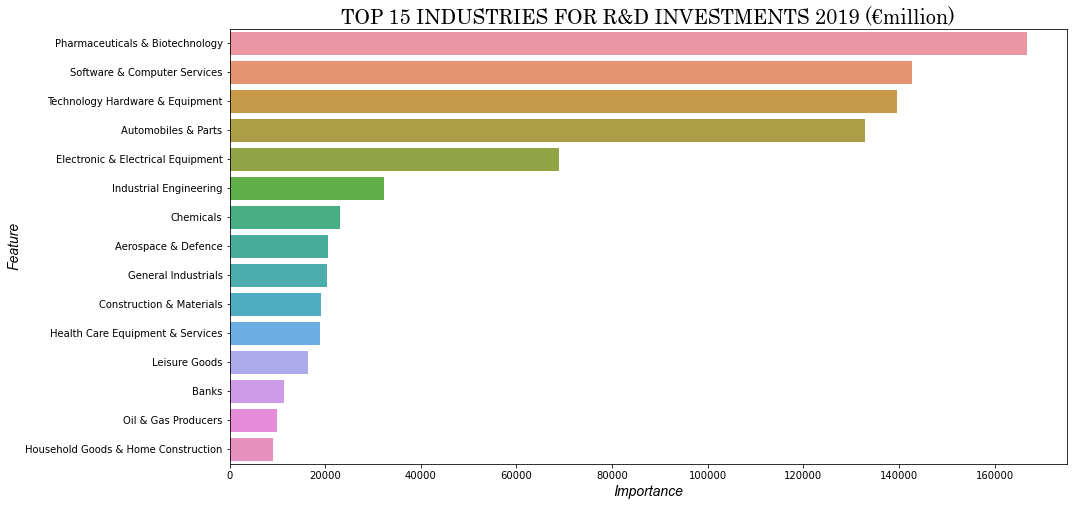

In [20]:
plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['R&D 2019 (€million)'], 
            y = df_order[:15].index)
plt.title('TOP 15 INDUSTRIES FOR R&D INVESTMENTS 2019 (€million)', **csfont, size = 20)
plt.ylabel('Feature', **hfont, size = 14, style = 'italic')
plt.xlabel('Importance', **hfont, size = 14, style = 'italic')

In [21]:
df_order = df_industry_sum.sort_values(by='Employees', ascending = False)

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Employees', ylabel='Industry'>

Text(0.5, 1.0, 'TOP 15 INDUSTRIES FOR EMPLOYEES')

Text(0, 0.5, 'Feature')

Text(0.5, 0, 'Importance')

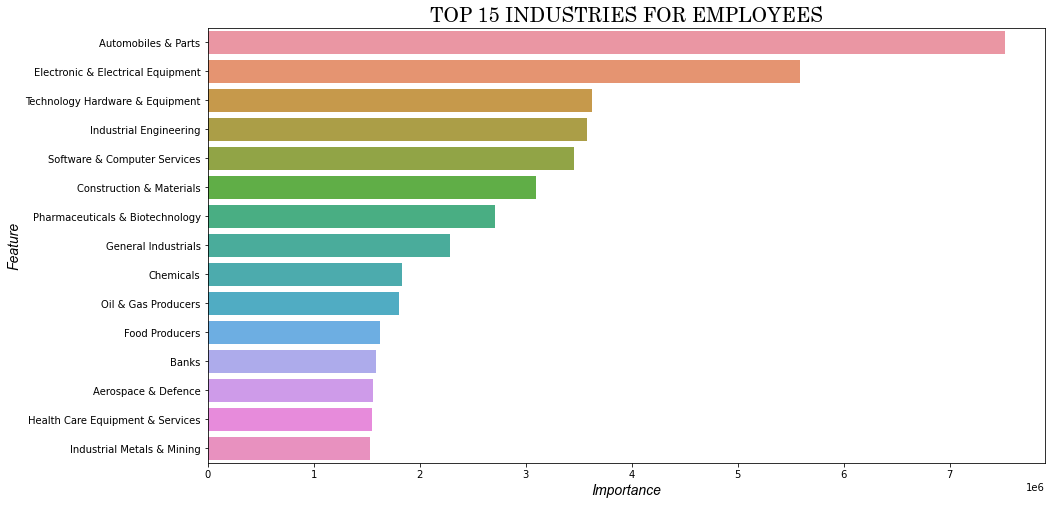

In [22]:
plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['Employees'], 
            y = df_order[:15].index)
plt.title('TOP 15 INDUSTRIES FOR EMPLOYEES', **csfont, size = 20)
plt.ylabel('Feature', **hfont, size = 14, style = 'italic')
plt.xlabel('Importance', **hfont, size = 14, style = 'italic')

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Net sales (€million)', ylabel='Industry'>

Text(0.5, 1.0, 'TOP 15 INDUSTRIES FOR Net sales')

Text(0, 0.5, 'Feature')

Text(0.5, 0, 'Importance')

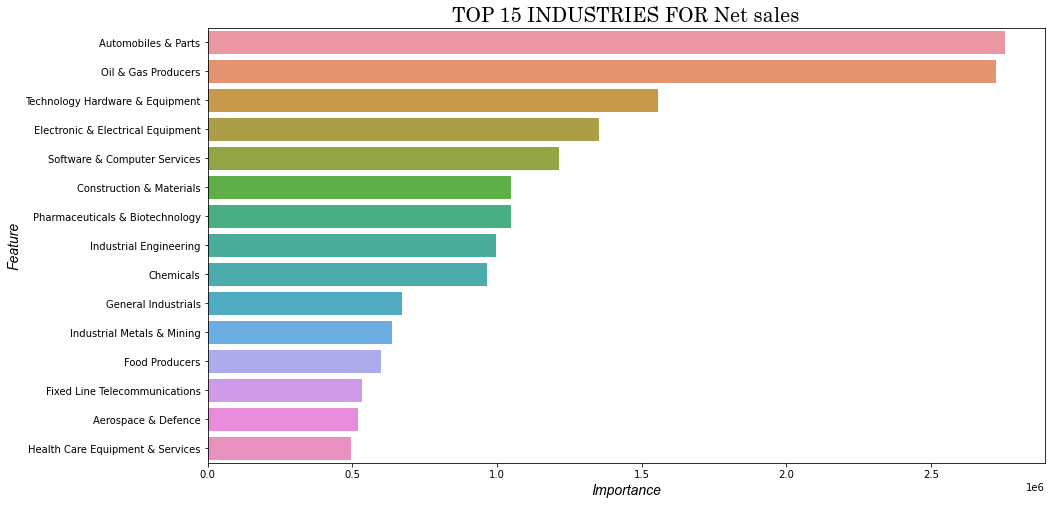

In [23]:
df_order = df_industry_sum.sort_values(by='Net sales (€million)', ascending = False)
plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['Net sales (€million)'], 
            y = df_order[:15].index)
plt.title('TOP 15 INDUSTRIES FOR Net sales', **csfont, size = 20)
plt.ylabel('Feature', **hfont, size = 14, style = 'italic')
plt.xlabel('Importance', **hfont, size = 14, style = 'italic')

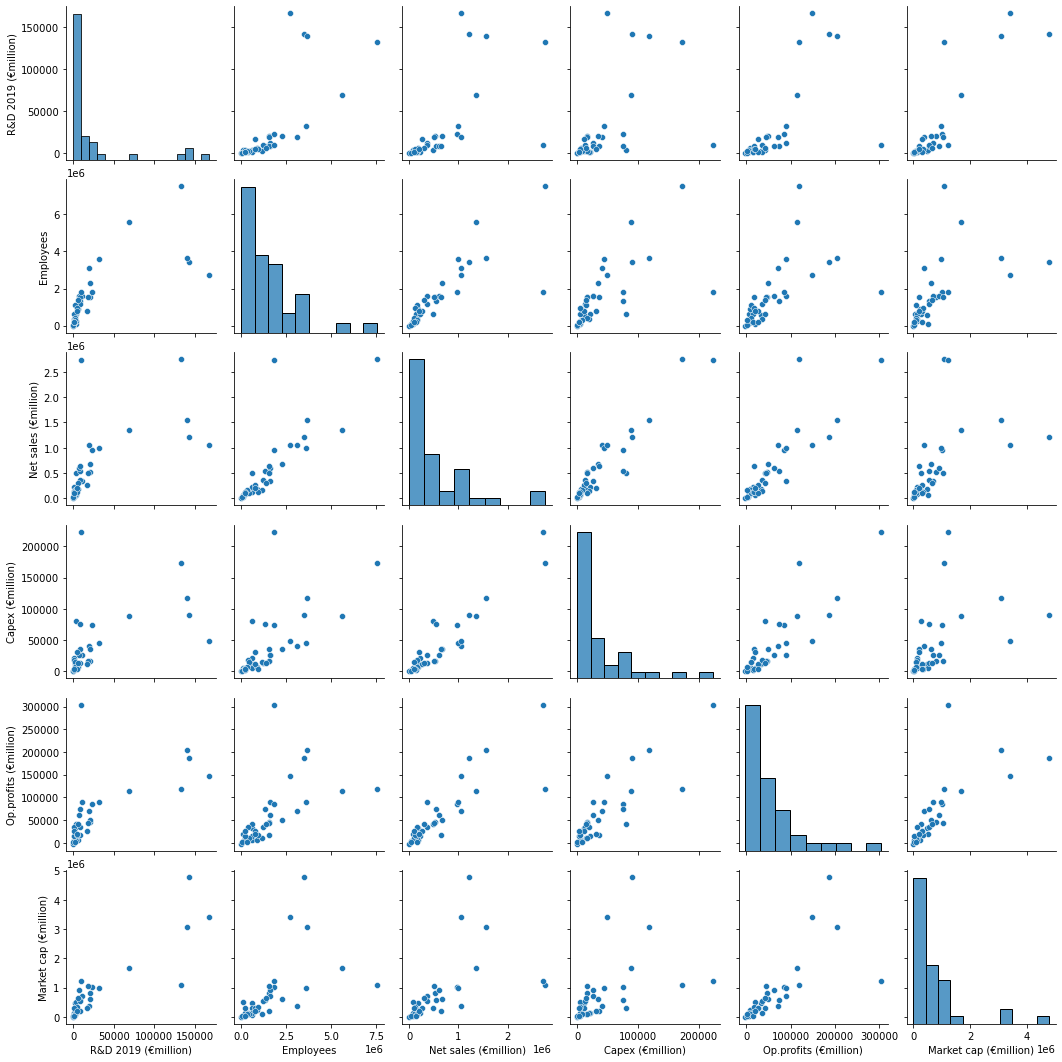

In [381]:
sns.pairplot(df_industry_sum)

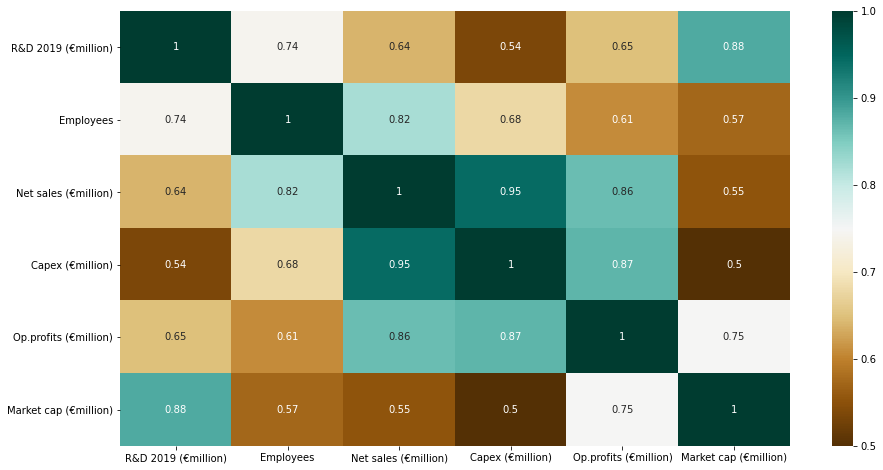

In [383]:
plt.figure(figsize = (15,8))
cormap = np.corrcoef(df_industry_sum.values.T).round(2)
g = sns.heatmap(df_industry_sum.corr(), cbar=True, annot = True, cmap='BrBG', yticklabels = df_industry_sum.columns, xticklabels=df_industry_sum.columns)